In [1]:
import pandas as pd
import numpy as np
import sys
import os
pd.set_option('display.max_columns', None)
%load_ext autoreload
%autoreload 2

import matplotlib.pyplot as plt

In [2]:
from venn import venn
from sklearn.preprocessing import StandardScaler
import seaborn as sns
import scipy.cluster.hierarchy as shc
from scipy.cluster.hierarchy import cut_tree

In [6]:
from motifclustering.features_extraction import MotifProperties

# Data loading

In [3]:
### Open motifs files for each tool
#
motif_merci = pd.read_csv('../data/merci_lst_motifs.txt',
                          header=None,
                          names=['motif'])

motif_streme = pd.read_csv('../data/lst_motifs_fimo_streme.txt',
                          header=None,
                          names=['motif'])

motif_dimotif = pd.read_csv('../data/dimotif_lst_motifs.txt',
                          header=None,
                          names=['motif'])

### Add a 'tool' column to keep track
#
motif_merci['tool'] = 'merci'
motif_streme['tool'] = 'streme'
motif_dimotif['tool'] = 'dimotif'

print('dimotif', motif_dimotif.shape[0])
print('streme', motif_streme.shape[0])
print('merci', motif_merci.shape[0])

dimotif 100
streme 91
merci 10


# Are there common core motifs ?

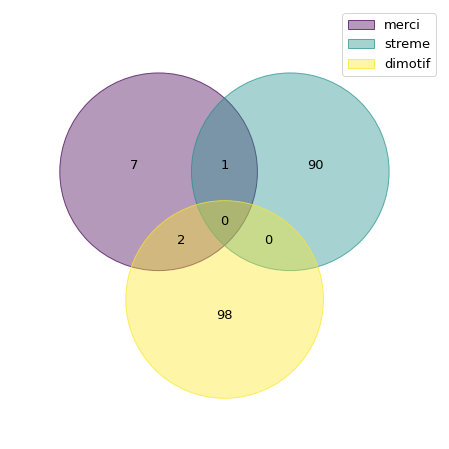

In [4]:
### Create and display a venn diagram of the core motifs
#
motifs = {
    'merci': set(motif_merci.motif),
    'streme': set(motif_streme.motif),
    'dimotif': set(motif_dimotif.motif)
}
venn(motifs);

> There are no common core motifs between the 3 tools. Maybe there are common motifs or degenerated motifs but at the chemical level.

# Motifs clustering based of physic and chemical properties

## Features extraction from the motif sequences.

In [7]:
### Compute features values for each list of motifs
#
lst_df = [motif_merci, motif_streme, motif_dimotif]
for i in range(len(lst_df)):
    props = MotifProperties()
    props.extract_properties(lst_df[i].motif, ph=7.5)
    lst_df[i] = lst_df[i].merge(props.export_as_dataframe(),
                                on='motif')
df_motifs = pd.concat(lst_df)
df_motifs.tool.value_counts()

dimotif    100
streme      91
merci       10
Name: tool, dtype: int64

> We have the same number of line per tool than before. Check Ok !

In [8]:
df_motifs.columns[2:]

Index(['seq_len', 'avg_mol_wt', 'gravy', 'isoelec_point', 'charge_at_pH',
       'molar_ext_coef', 'tiny', 'small', 'aliphatic', 'aromatic', 'non_polar',
       'polar', 'charged', 'basic', 'acidic', 'helix', 'turn', 'sheet'],
      dtype='object')

> 18 features in total.

## Data scaling

In [9]:
### Creates a copy of the original dataframe
#
df_motifs_scl = df_motifs.copy()

### Delete the tool column (useless from now)
#
df_motifs_scl.drop(columns='tool', inplace=True)

### Drop duplicated lines (e.g. motifs that are present several times)
#
df_motifs_scl = df_motifs_scl.drop_duplicates()

### Set the motifs as index
#
df_motifs_scl.set_index('motif', inplace=True)

### Rescale the data
#
#   Here, we use Standard Scaling
df_motifs_scl = pd.DataFrame(StandardScaler().fit_transform(df_motifs_scl),
                             index=df_motifs_scl.index,
                             columns=df_motifs_scl.columns)

### Print basic statistics for each features
#
df_motifs_scl.describe()

,seq_len,avg_mol_wt,gravy,isoelec_point,charge_at_pH,molar_ext_coef,tiny,small,aliphatic,aromatic,non_polar,polar,charged,basic,acidic,helix,turn,sheet
count,1.980000e+02,1.980000e+02,1.980000e+02,1.980000e+02,1.980000e+02,1.980000e+02,1.980000e+02,1.980000e+02,1.980000e+02,1.980000e+02,1.980000e+02,1.980000e+02,1.980000e+02,1.980000e+02,1.980000e+02,1.980000e+02,1.980000e+02,1.980000e+02
mean,-2.870880e-16,-5.674473e-16,5.382900e-17,-8.971499e-17,-3.588600e-17,5.607187e-17,-2.242875e-16,-2.018587e-17,1.256010e-16,6.728624e-18,-2.018587e-17,2.489591e-16,-1.525155e-16,-1.256010e-16,7.177199e-17,9.868649e-17,1.345725e-16,8.971499e-18
std,1.002535e+00,1.002535e+00,1.002535e+00,1.002535e+00,1.002535e+00,1.002535e+00,1.002535e+00,1.002535e+00,1.002535e+00,1.002535e+00,1.002535e+00,1.002535e+00,1.002535e+00,1.002535e+00,1.002535e+00,1.002535e+00,1.002535e+00,1.002535e+00
min,-3.326337e+00,-2.647799e+00,-1.493468e+00,-1.256497e+00,-2.263745e+00,-3.447375e-01,-1.105362e+00,-1.511629e+00,-7.523600e-01,-5.982727e-01,-1.511629e+00,-1.658949e+00,-1.083694e+00,-9.261057e-01,-8.095620e-01,-7.818649e-01,-1.025656e+00,-9.927900e-01
25%,-3.394221e-01,-6.786101e-01,-7.910366e-01,-6.502254e-01,-4.216321e-01,-3.447375e-01,-1.105362e+00,-7.189846e-01,-7.523600e-01,-5.982727e-01,-7.189846e-01,-8.663044e-01,-1.083694e+00,-9.261057e-01,-8.095620e-01,-7.818649e-01,-1.025656e+00,-9.927900e-01
50%,-3.394221e-01,1.435726e-01,-9.396717e-02,-4.685989e-01,-1.118443e-01,-3.447375e-01,-1.952081e-01,7.365990e-02,-7.523600e-01,-5.982727e-01,7.365990e-02,-7.365990e-02,-3.531967e-01,-2.502988e-02,-8.095620e-01,-3.712303e-01,-4.742916e-02,1.274936e-01
75%,1.154035e+00,8.022498e-01,6.754903e-01,9.894148e-01,8.012155e-01,-3.447375e-01,7.149458e-01,8.663044e-01,4.330560e-01,6.324597e-01,8.663044e-01,7.189846e-01,1.046923e+00,8.760459e-01,8.227524e-01,2.447217e-01,9.307973e-01,7.996637e-01
max,1.154035e+00,2.914490e+00,2.474466e+00,2.177048e+00,3.644134e+00,7.590984e+00,2.535254e+00,1.658949e+00,2.803888e+00,5.555390e+00,1.658949e+00,1.511629e+00,1.838295e+00,2.678197e+00,2.863145e+00,3.324481e+00,2.887250e+00,2.368061e+00


> All the features are ~in the same range. Theses features can be used with distance based clustering methods.

<AxesSubplot:>

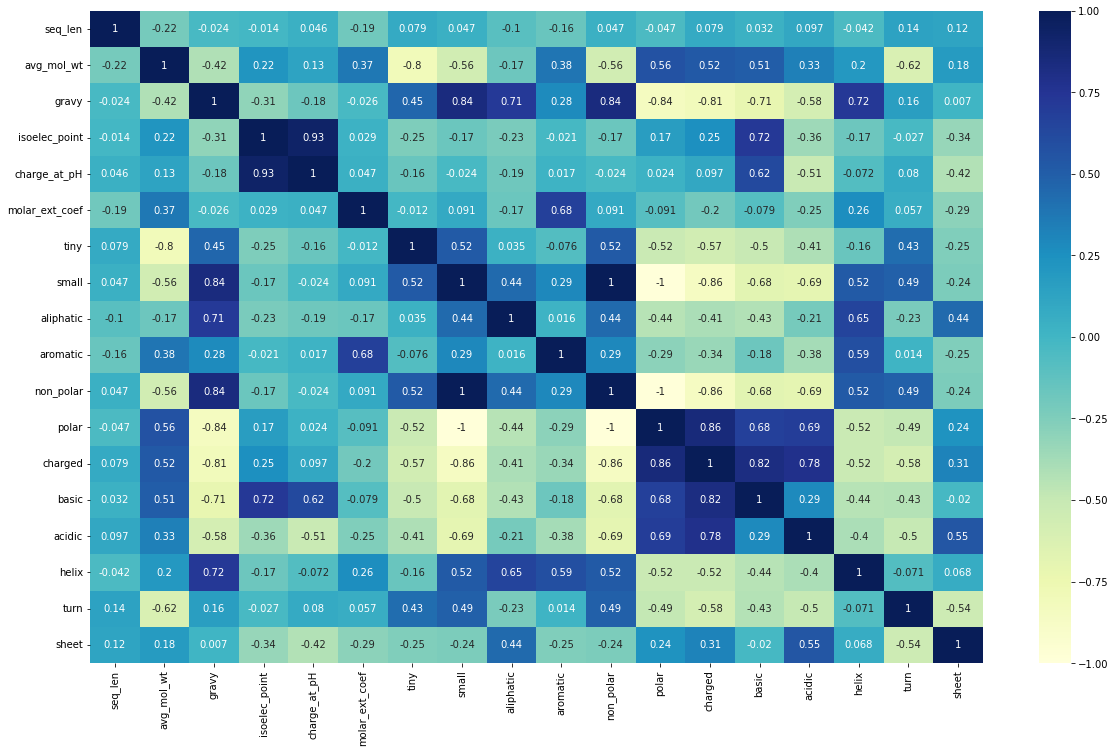

In [10]:
### Create a correlation matrix
#
fig =plt.figure(figsize=(20,12))
sns.heatmap(df_motifs_scl.corr(), cmap="YlGnBu", annot=True)

> A lot of explicative features shows multicollinearity 

## PCA

Although not mandatory, doing PCA first helps to separate data more easily.

In [11]:
from sklearn.decomposition import PCA

### PCA fitting 
#
pca = PCA()
pca.fit(df_motifs_scl)

### Getting the projections
#
df_motifs_scl_proj = pd.DataFrame(pca.transform(df_motifs_scl), 
                                  columns=[f'PC{i}' for i in range(1, df_motifs_scl.shape[1]+1)],
                                  index=df_motifs_scl.index)

df_motifs_scl_proj

,PC1,PC2,PC3,PC4,PC5,PC6,PC7,PC8,PC9,PC10,PC11,PC12,PC13,PC14,PC15,PC16,PC17,PC18
motif,,,,,,,,,,,,,,,,,,
GHWT,-0.786733,2.121955,2.195142,2.931069,-0.356307,-1.808070,0.511662,-0.214262,-0.268310,0.511583,0.013521,-0.045642,0.317419,-0.235730,-0.039503,-6.794233e-16,-4.299582e-16,-3.590704e-16
GHWTQ,-0.254603,1.892870,1.719491,2.649389,-1.537418,-1.760860,1.042862,0.249289,-0.708227,0.031101,0.539465,-0.123391,0.377372,-0.311197,-0.073048,-1.044795e-15,-1.225996e-16,-6.290615e-16
HWT,0.459974,2.212675,4.184778,3.285007,0.786578,-1.714119,-0.017202,0.104190,0.282989,0.416433,0.137652,0.070861,0.274923,-0.028293,0.025832,-4.311068e-16,-2.364162e-16,-3.447831e-16
HWTQ,0.813965,1.928293,3.235007,2.954911,-0.294686,-1.576045,0.720747,0.461390,-0.332385,-0.122135,0.644752,-0.027345,0.310704,-0.224201,-0.022824,-8.492861e-16,7.164093e-17,-4.993609e-16
PGNV,-2.642249,0.636831,-1.166111,-0.042844,0.396996,1.648433,0.477286,-0.109658,-0.392980,0.232270,0.056757,0.215116,-0.002863,-0.070310,-0.091946,2.501083e-16,1.766670e-16,-9.100596e-18
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
VHAA,-2.273507,-1.102261,1.009996,-2.104108,0.760909,-1.513609,0.173206,-0.298168,0.494191,1.374893,0.759227,0.143793,0.402694,0.121486,-0.037418,-4.627841e-16,-9.364167e-17,1.729523e-17
VKSY,-0.707856,1.763670,1.704467,-0.301924,0.124322,0.055873,0.145778,0.656510,-0.256383,0.338974,-0.175905,-0.447128,-0.158662,-0.024508,0.116120,-5.351084e-16,1.446715e-16,-1.451371e-16
KTD,3.072806,-0.015688,-0.370213,0.951173,2.102826,-0.060755,-0.537991,1.054649,-0.389287,0.037545,-0.102575,0.066980,-0.269591,-0.156445,0.006086,-7.746512e-16,2.935620e-16,-1.650605e-17


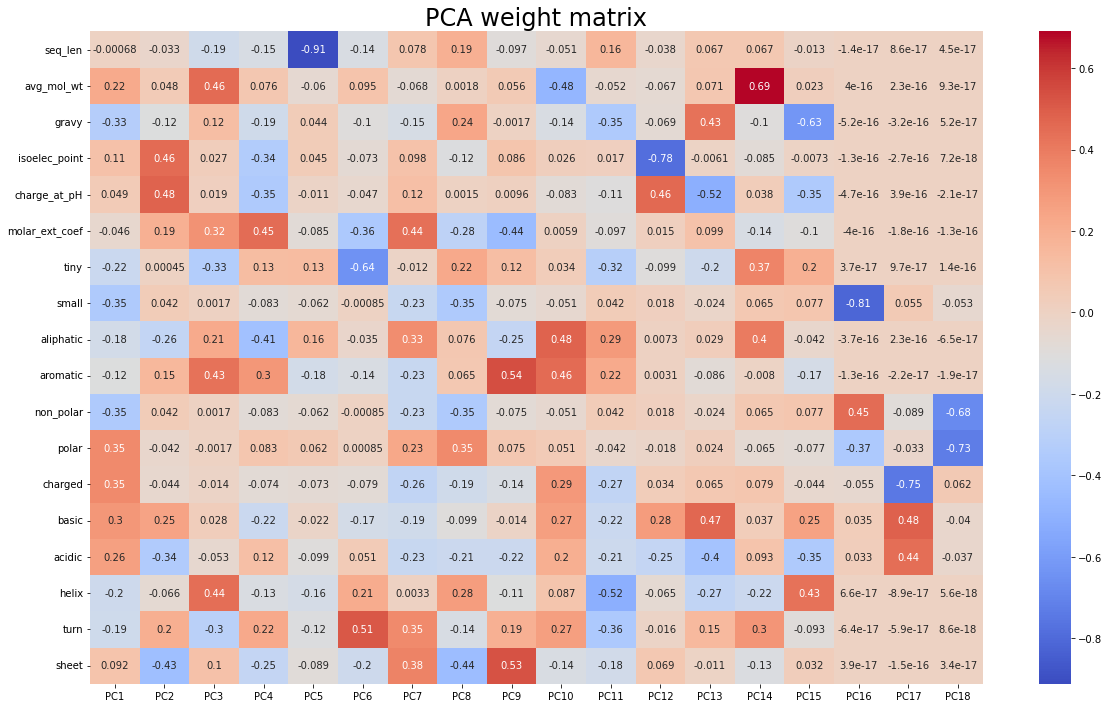

In [12]:
### Access features 'importance' in our PCs 
#
W = pca.components_
W = pd.DataFrame(W.T,
                 index=df_motifs_scl.columns,
                 columns=[f'PC{i}' for i in range(1, df_motifs_scl_proj.shape[1]+1)])

### Create a heatmap from the weight matrix
#
fig =plt.figure(figsize=(20,12))
sns.heatmap(W, cmap='coolwarm', annot=True)
plt.title('PCA weight matrix', fontsize=24);

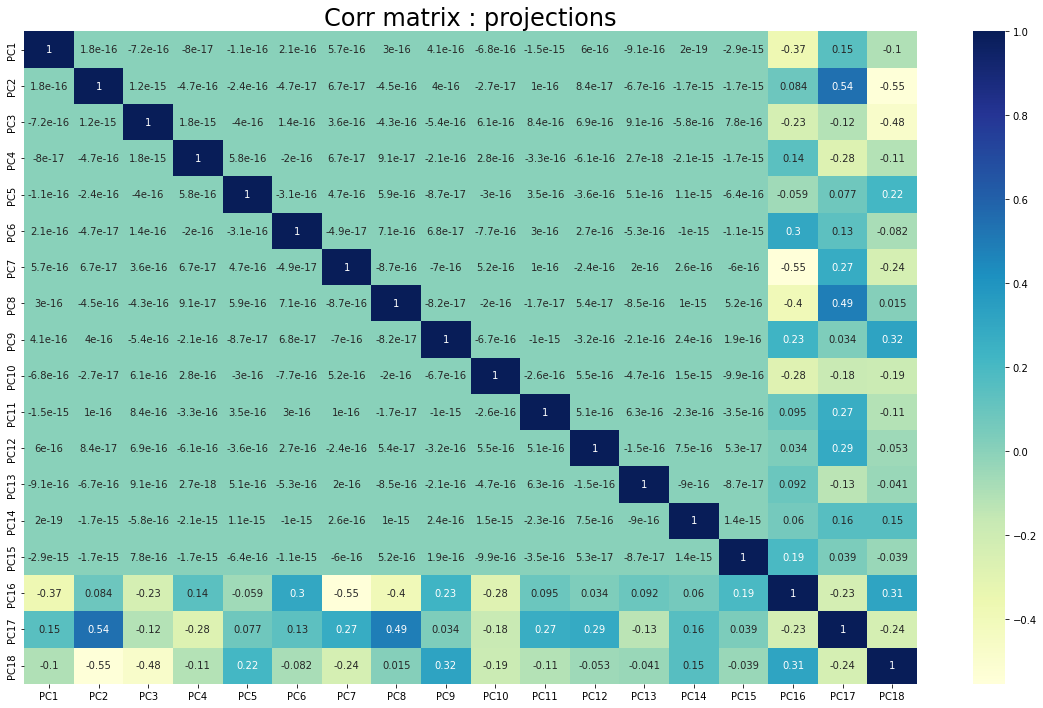

In [13]:
### Create a correlation matrix
#
fig =plt.figure(figsize=(20,12))
sns.heatmap(df_motifs_scl_proj.corr(), cmap="YlGnBu", annot=True)
plt.title('Corr matrix : projections', fontsize=24);

> As expected, the PCA reduces multicolinearity to its maximum!

In [14]:
### Proportion of explained variance
#
pd.DataFrame({
    'Component':[f'PC{i}' for i in range(1, len(pca.explained_variance_ratio_)+1)],
    'variance_ratio':np.around(pca.explained_variance_ratio_, 6),
    'cum_sum':np.cumsum(pca.explained_variance_ratio_)
})
#np.around(pca.explained_variance_ratio_, 4)

,Component,variance_ratio,cum_sum
0,PC1,0.413976,0.413976
1,PC2,0.174589,0.588564
2,PC3,0.150994,0.739559
3,PC4,0.097333,0.836892
4,PC5,0.055324,0.892216
5,PC6,0.033969,0.926185
6,PC7,0.021550,0.947735
7,PC8,0.019650,0.967385
8,PC9,0.013353,0.980738
9,PC10,0.008662,0.989400


> The first component count for 41 % of the total data variance !

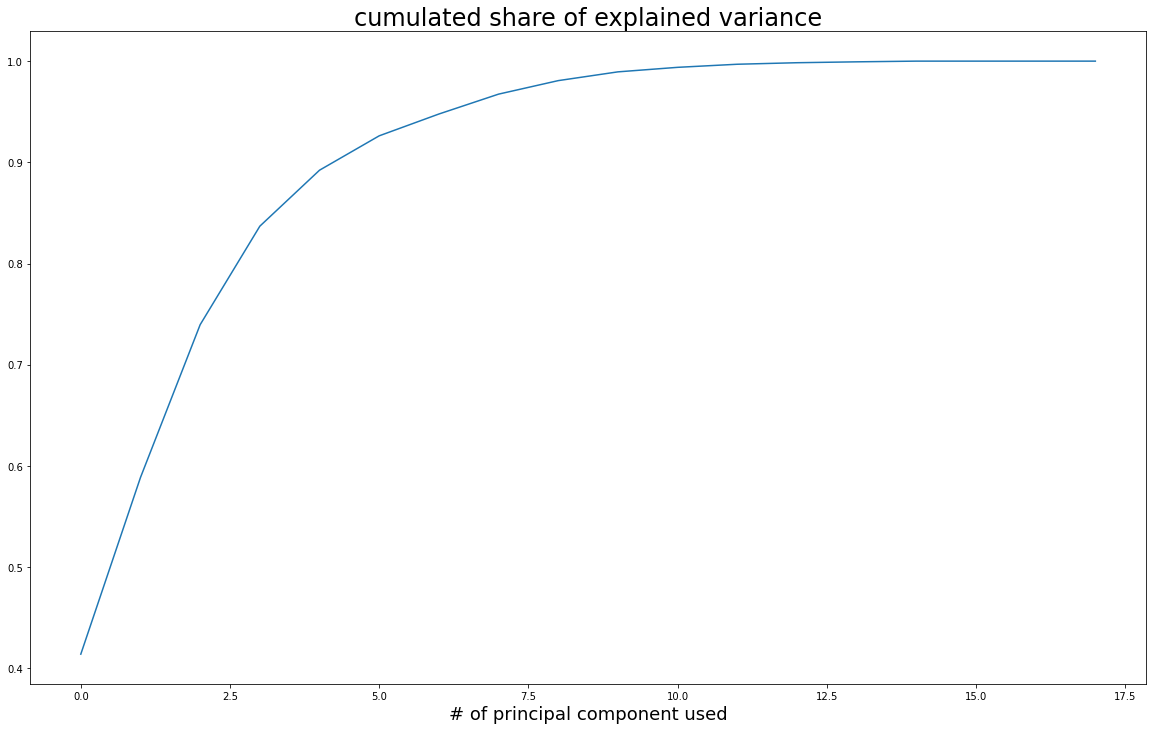

In [15]:
fig = plt.figure(figsize=(20, 12))
plt.plot(np.cumsum(pca.explained_variance_ratio_))
plt.title('cumulated share of explained variance', fontsize=24)
plt.xlabel('# of principal component used', fontsize=18);

## Clustering

### Hierarchical clustering

In [16]:
### Perform hierarchical/agglomerative clustering.
#
link_matrix = shc.linkage(df_motifs_scl_proj, method='ward')

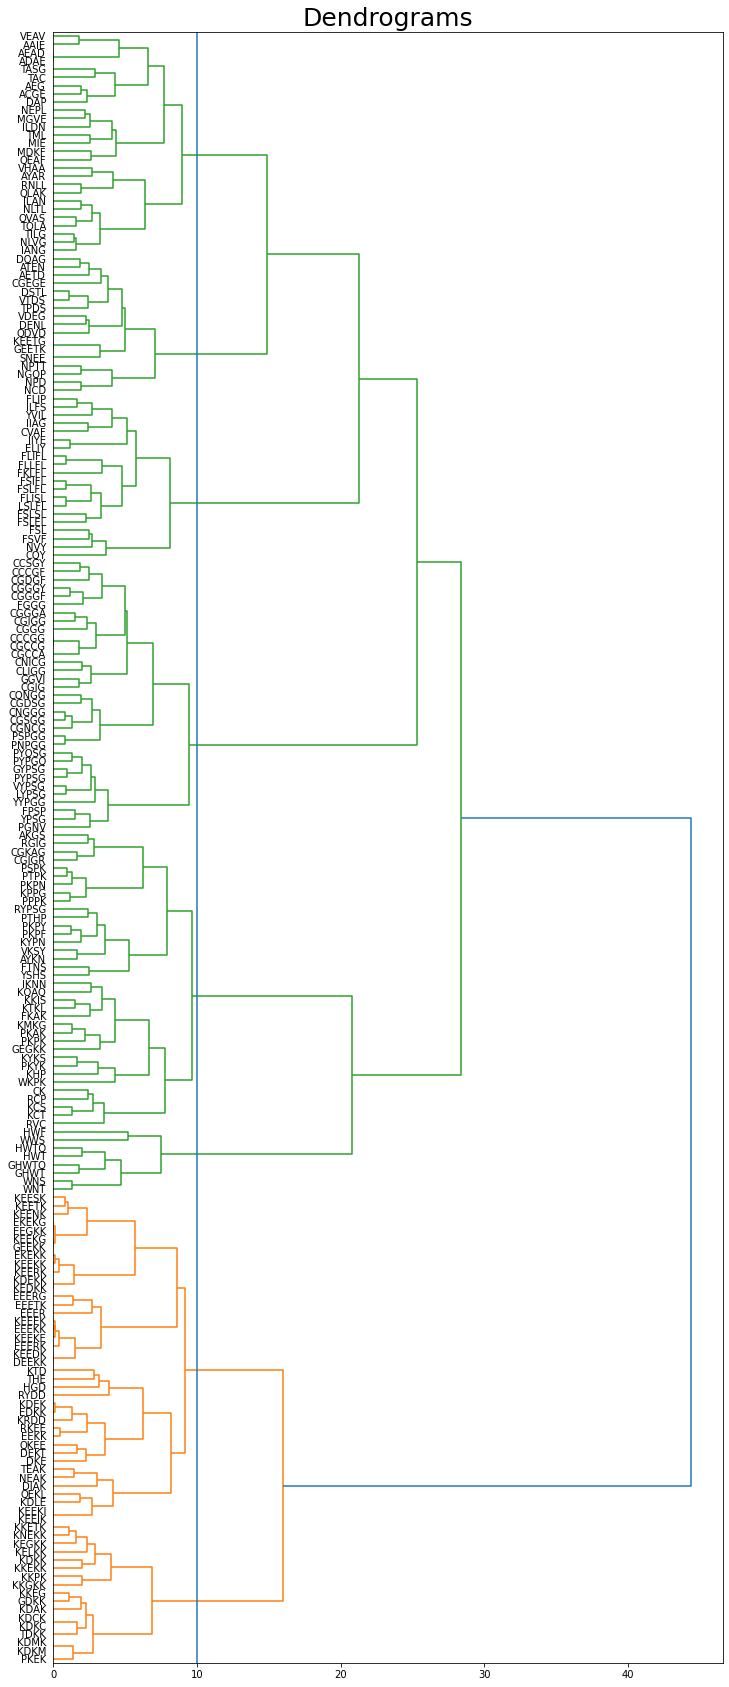

In [17]:
### Dendogram for Heirarchical Clustering and add a vertical line
#
#   https://python-graph-gallery.com/401-customised-dendrogram
#   https://stackabuse.com/hierarchical-clustering-with-python-and-scikit-learn/
fig = plt.figure(figsize=(12, 30))
dend = shc.dendrogram(link_matrix, 
                     labels=df_motifs_scl_proj.index,
                     leaf_font_size=10, 
                     orientation='right')
plt.axvline(x=10)
plt.title("Dendrograms", fontsize=25);



In [20]:
### Assign clusters label to each motif
#
#   The height (e.g. distance) value correspond to the vertical blue line
#   on the tree. The tree is cutted to this height. The number of clusters
#   can be deduced from the number of intersections between the tree branchs
#   and the vertical blue line. 
#   https://docs.scipy.org/doc/scipy/reference/generated/scipy.cluster.hierarchy.cut_tree.html
motifs_clusters = pd.DataFrame({'motif':df_motifs_scl_proj.index,
                                'cluster':cut_tree(link_matrix, height=10).ravel()})
motifs_clusters.head(5)

,motif,cluster
0,GHWT,0
1,GHWTQ,0
2,HWT,0
3,HWTQ,0
4,PGNV,1


> motifs_clusters dataframe link each motif to its cluster label.

In [21]:
### Count the number of motifs contained in each cluster
#
cnt_motifs_per_clust = pd.DataFrame(motifs_clusters.cluster.value_counts().reset_index())
cnt_motifs_per_clust.columns = ['cluster', 'cnt']
cnt_motifs_per_clust

,cluster,cnt
0,4,40
1,2,36
2,1,33
3,3,27
4,5,20
5,6,17
6,7,17
7,0,8


> Clusters size is highly variable. The cluster 4 will lead to the creation of a consensus motif from 40 discovered motifs !

In [19]:
### Display the motifs in the cluster '0'
#
motifs_clusters[motifs_clusters.cluster==0].motif

0       GHWT
1      GHWTQ
2        HWT
3       HWTQ
108      WWS
119      WNT
154      WNS
166      HWF
Name: motif, dtype: object

> The cluster 0 indeed contains 8 motifs. This clustering is consistent with the tree.